In [16]:
# Importieren von Bibliotheken
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

import numpy as np
from matplotlib import pyplot as plt

In [17]:
########################################### Funktionen ############################################################################################

def kinetic (circuit, phi):     # Gates zur Simulation der Zeitentwicklung durch H_0
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden

    for i in range(n):
        circuit.p(-phi*2**(i+1),i+1)
        for j in range(i+1,n):
            circuit.cx(j+1,0)
            circuit.cx(i+1,0)
            circuit.p(-phi*2**(i+j+1),0)
            circuit.cx(i+1,0)
            circuit.cx(j+1,0)

    return circuit

def potential (circuit, V):     # Gates zur Simulation der Potentialstufe
    n = circuit.num_qubits - 1
    circuit.p(V, n)

def timeEv (circuit, q, phi, V, iterations):      # Zeitentwicklung
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden
    for i in range(iterations):
        circuit.append(QFT(n), q[1:])
        kinetic(circuit=circuit, phi=phi)
        circuit.append(QFT(n, inverse=True), q[1:])
        potential(circuit=circuit, V=V)

    return circuit

In [18]:
########################################### Startparameter ########################################################################################

n = 6   # Anzahl Qubits
N = 2**n    # Anzahl Gitterpunkte

phi = 0.01
phi = phi/4     # Phasenfaktor

V = 1       # Höhe der Potentialstufe

# Ortsraumgitter
x_min = -2
x_max = 2
x = np.linspace(x_min, x_max, num=N)

# Gaußsches Wellenpaket als Anfangszustand
mu=-1
sigma = 0.3
psi= np.sqrt(1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(0.5*(x-mu)**2)/(sigma**2))) * np.exp(-65j*x)
psi/= np.sqrt(np.sum(np.abs(psi**2)))

#plt.plot(x, psi)

In [19]:
########################################### Simulation Zustandsvektor ############################################################################

q = QuantumRegister(n+1)    # Erzeugen eines Quantenregisters mit zusätzlichem ancilla-Qubit
circuit = QuantumCircuit(q)   # Erstellen eines circuits

# Initialisierung des Anfangszustandes
circuit.initialize(psi,q[1:])

simulator = Aer.get_backend('statevector_simulator')    # Festlegen des Simulators, hier Zustandsvektor-Simulator

prob_ev = []    # Array, in dem die Zeitentwicklung der Wahrscheinlichkeitsdichte gespeichert wird

# Speichern des Anfangszustandsvektors 
statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
prob = statevector.probabilities()
prob = prob[::2]
prob_ev.append(prob)

# Simulation der Zustandsvektoren der einzelnen Zeitschritte 
it = 5
rg = 7      # Anzahl der Zeitzwischenschritte die geplottet werden sollen

for i in range(rg):
    timeEv(circuit=circuit, q=q, phi=phi, V=V, iterations=it)
    prob = []
    statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
    print(str(i) + ':' + str(statevector.is_valid()))       # Überprüfung ob Zustandsvektor normiert ist, Ausgabe um Fortschritt der Simulation zu verfolgen
    prob = statevector.probabilities()
    prob = prob[::2]
    prob_ev.append(prob)

0:True
1:True
2:True
3:True
4:True
5:True
6:True


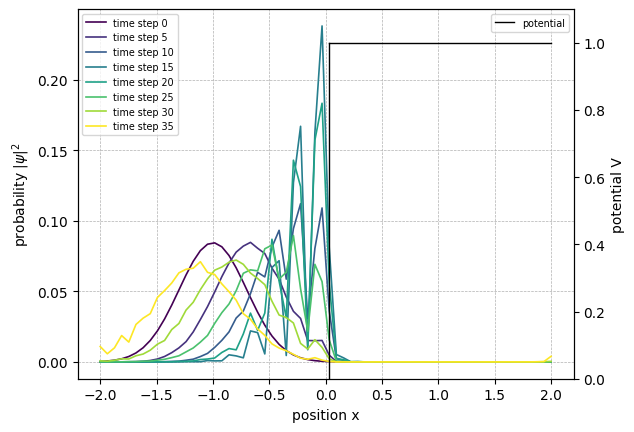

In [20]:
########################################### Plots ################################################################################################

colors = plt.cm.viridis(np.linspace(0,1,rg+1))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()           # zweite y-Achse

# time steps
for i in range(len(prob_ev)):
    ax1.plot(x, prob_ev[i], color=colors[i], linewidth=1.2, label='time step ' + str(i*it))

# Potential
ax2.plot([x[32], x[32]], [0, V], color='black', linewidth=1, label='potential')
ax2.plot(x[32:], np.full(32, V), color='black', linewidth=1)


ax1.set_xlabel('position x')
ax1.set_ylabel(r'probability $|\psi|^2$')
ax2.set_ylim(0.0, 1.1)
ax2.set_ylabel('potential V')
ax1.legend(loc='upper left', fontsize='x-small')
ax2.legend(loc='upper right', fontsize='x-small')
ax1.grid(linestyle='--', linewidth=0.5)

#fig.savefig('timeev_potentialstufe_1.jpg', bbox_inches="tight",dpi=300)